In [1]:
import sys

COMMON_DIR = "/mnt/d/github/computer_vision/books/generative_deep_learning/pytorch/common"
if COMMON_DIR not in sys.path:
    sys.path.append(COMMON_DIR)

from common.datasets import get_train_loader, get_test_loader
from common.utils import set_seed, plot_images, create_images
from common.trainer import fit, evaluate, predict

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as T

In [3]:
### Data Loading
from common.datasets import FashionMNIST

root_dir = "/mnt/d/datasets/fashion_mnist"
train_loader = get_train_loader(dataset=FashionMNIST(root_dir, "train"), batch_size=100)
test_loader = get_test_loader(dataset=FashionMNIST(root_dir, "test"), batch_size=64)

batch = next(iter(train_loader))
images, labels = batch["image"], batch["label"]
print(f"\ntrain dataset: {len(train_loader.dataset)}, dataloader: {len(train_loader)}")
print(f"train images: {images.shape}, {images.dtype}, {images.min()}, {images.max()}")
print(f"train labels: {labels.shape}, {labels.dtype}, {labels.min()}, {labels.max()}")

batch = next(iter(test_loader))
images, labels = batch["image"], batch["label"]
print(f"\ntest dataset: {len(test_loader.dataset)}, dataloader: {len(test_loader)}")
print(f"test  images: {images.shape}, {images.dtype}, {images.min()}, {images.max()}")
print(f"test  labels: {labels.shape}, {labels.dtype}, {labels.min()}, {labels.max()}")


train dataset: 60000, dataloader: 600
train images: torch.Size([100, 1, 32, 32]), torch.float32, 0.0, 1.0
train labels: torch.Size([100]), torch.int64, 0, 9

test dataset: 10000, dataloader: 157
test  images: torch.Size([64, 1, 32, 32]), torch.float32, 0.0, 1.0
test  labels: torch.Size([64]), torch.int64, 0, 9


In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=2, in_channels=1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.fc1 = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc2 = nn.Linear(128 * 4 * 4, latent_dim)
        self.latent_dim = latent_dim

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(mu)
        return mu + std * eps

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 128 * 4 * 4)
        mu, logvar = self.fc1(x), self.fc2(x)
        latent = self.reparameterize(mu, logvar)
        return latent, mu, logvar

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=2, out_channels=1):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 128 * 4 * 4)
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
        )
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
        )
        self.deconv3 = nn.ConvTranspose2d(32, out_channels,
            kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 128, 4, 4)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = torch.sigmoid(x)    # nn.BCELoss()
        return x    # recon

In [6]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder, beta=500, device=None):
        super().__init__()
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.encoder = encoder.to(self.device)
        self.decoder = decoder.to(self.device)
        self.beta = beta
        self.bce_loss = nn.BCELoss(reduction='none')
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, images):
        latent, mu, logvar = self.encoder(images)
        recon = self.decoder(latent)
        return recon, latent, mu, logvar

    def loss_fn(self, recon, images, mu, logvar):
        bce_pixel = self.bce_loss(recon, images)
        bce = bce_pixel.view(bce_pixel.size(0), -1).mean(dim=1)    # (B,)
        bce = self.beta * bce.mean() 

        kld_sample = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)  # (B,)
        kld = kld_sample.mean()

        loss =  bce + kld
        return loss, bce, kld

    def train_step(self, batch):
        images = batch["image"].to(self.device)
        self.optimizer.zero_grad()
        recon, latent, mu, logvar = self.forward(images)
        loss, bce, kld = self.loss_fn(recon, images, mu, logvar)
        loss.backward()
        self.optimizer.step()
        return dict(loss=loss, bce=bce, kld=kld)

    @torch.no_grad()
    def eval_step(self, batch):
        images = batch["image"].to(self.device)
        recon, latent, mu, logvar = self.forward(images)
        loss, bce, kld = self.loss_fn(recon, images, mu, logvar)
        return dict(loss=loss, bce=bce, kld=kld)

    @torch.no_grad()
    def pred_step(self, batch):
        images = batch["image"].to(self.device)
        labels = batch["label"]
        recon, latent, mu, logvar = self.forward(images)
        return dict(image=images, label=labels, latent=latent, recon=recon)

In [ ]:
encoder = Encoder(latent_dim=2, in_channels=1)
decoder = Decoder(latent_dim=2, out_channels=1)
model = VAE(encoder, decoder)

history = fit(model, train_loader, num_epochs=10, valid_loader=test_loader)

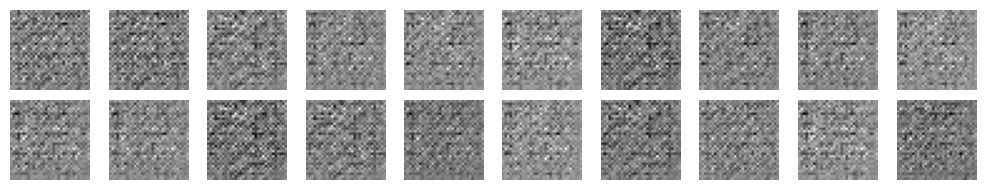

[  1/5] loss:151.338, bce:146.312, kld:5.026                                                   
[  2/5] loss:136.238, bce:131.392, kld:4.845                                                   
[  3/5] loss:134.579, bce:129.643, kld:4.935                                                   
[  4/5] loss:133.615, bce:128.595, kld:5.020                                                   
[  5/5] loss:133.052, bce:127.976, kld:5.076                                                   


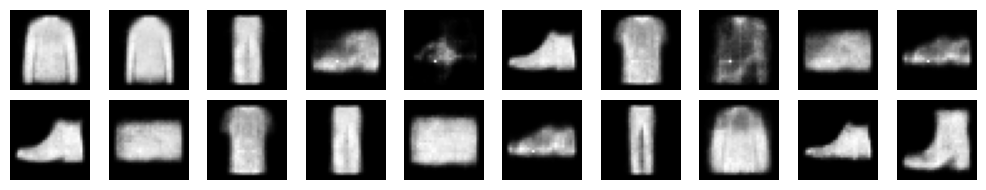

[  1/5] loss:132.612, bce:127.498, kld:5.114                                                   
[  2/5] loss:132.241, bce:127.102, kld:5.140                                                   
[  3/5] loss:131.956, bce:126.782, kld:5.174                                                   
[  4/5] loss:131.774, bce:126.571, kld:5.203                                                   
[  5/5] loss:131.603, bce:126.377, kld:5.226                                                   


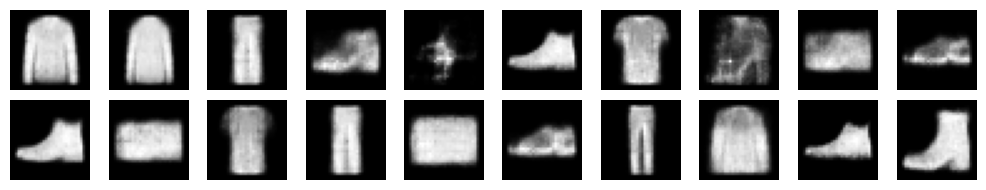

[  1/5] loss:131.401, bce:126.154, kld:5.246                                                   
[  2/5] loss:131.280, bce:126.017, kld:5.263                                                   
[  3/5] loss:131.104, bce:125.816, kld:5.288                                                   
[  4/5] loss:130.992, bce:125.701, kld:5.291                                                   
[  5/5] loss:130.871, bce:125.566, kld:5.305                                                    


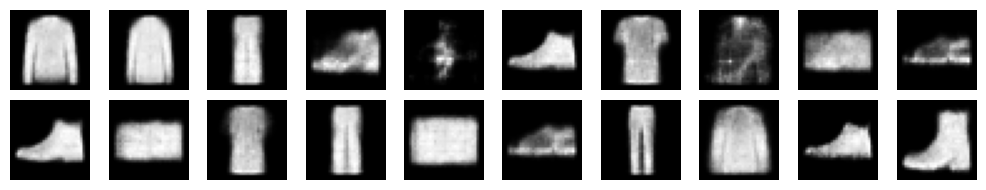

[  1/5] loss:130.783, bce:125.457, kld:5.326                                                   
[  2/5] loss:130.651, bce:125.330, kld:5.321                                                   
[  3/5] loss:130.588, bce:125.248, kld:5.340                                                   
[  4/5] loss:130.451, bce:125.112, kld:5.339                                                   
[  5/5] loss:130.389, bce:125.037, kld:5.352                                                    


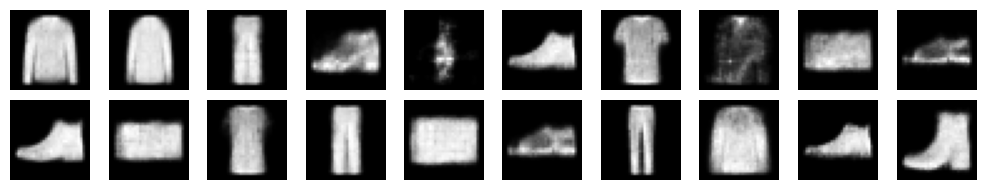

[  1/5] loss:130.279, bce:124.910, kld:5.369                                                   
[  2/5] loss:130.228, bce:124.842, kld:5.386                                                   
[  3/5] loss:130.154, bce:124.762, kld:5.392                                                   
[  4/5] loss:130.043, bce:124.646, kld:5.397                                                   
[  5/5] loss:129.987, bce:124.574, kld:5.413                                                   


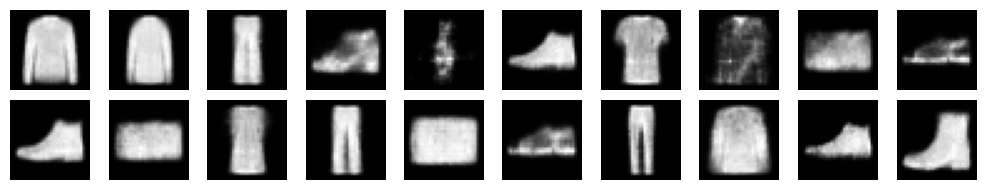

In [7]:
encoder = Encoder(latent_dim=2, in_channels=1)
decoder = Decoder(latent_dim=2, out_channels=1)
model = VAE(encoder, decoder)

z_sample = np.random.normal(size=(20, 2))
total_history = {}
images = create_images(decoder, z_sample)
plot_images(*images, ncols=10, xunit=1, yunit=1)

for _ in range(5):
    history = fit(model, train_loader, num_epochs=5)
    for split_name, metrics in history.items():
        total_history.setdefault(split_name, {})
        for metric_name, metric_values in metrics.items():
            total_history[split_name].setdefault(metric_name, [])
            total_history[split_name][metric_name].extend(metric_values)

    images = create_images(decoder, z_sample)
    plot_images(*images, ncols=10, xunit=1, yunit=1)

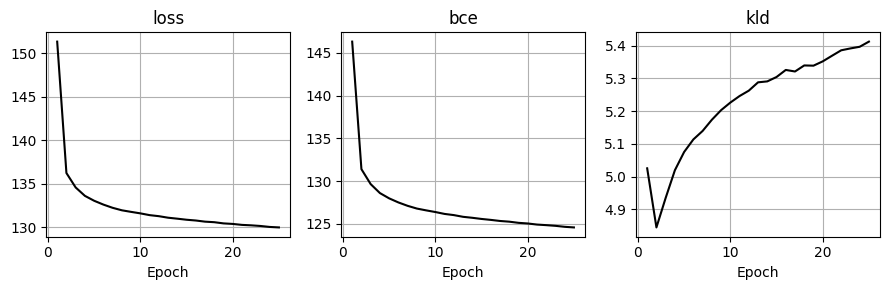

In [8]:
from common.utils import plot_history

plot_history(total_history["train"])